In [ ]:

import numpy as np 
import pandas as pd 
import seaborn as sns

import warnings
import matplotlib
from matplotlib import pyplot as plt
from scipy.stats import skew
import statsmodels.api as sm
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from scipy import stats
import statsmodels.stats.multitest as multi

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
warnings.filterwarnings("ignore")

# Business Understanding

Airbnb is a platform allowing house and apartment owner to rent their properties to guest for a short term stay. Due to the convenience and flexibility, it hasb been becoming one of the top choice for travelers. In this post, we will dive into Airbnb Seattle dataset and answer 3 business questions, mentioned below. 

The dataset is a collection of property listings, their key attributes such as the size of properties, availability of amenities, description of neighborhood, customers' reviews and much more.

Q1. As a traveler, should you choose an airbnb unit hosted by superhost?     

Q2. As a investor who want to purchase a property and run Airbnb business in Seattle, what kind of properties you should look at?   

Q3. How's the development of Airbnb in Seattle? Do you observe any pattern of trend?

# Data Understanding

In [76]:
#df_calendar = pd.read_csv("/kaggle/input/seattle/calendar.csv")
#df_listings = pd.read_csv("/kaggle/input/seattle/listings.csv")
#df_reviews = pd.read_csv("/kaggle/input/seattle/reviews.csv")

df_calendar = pd.read_csv("/content/calendar.csv")
df_listings = pd.read_csv("/content/listings.csv")
df_reviews = pd.read_csv("/content/reviews.csv")

for data in [df_calendar,df_listings,df_reviews]:
    display(data.head())
    print(data.shape)

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


(1393570, 4)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,NaN,NaN,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,NaN,956883,https://www.airbnb.com/users/show/956883,Maija,2011-08-11,"Seattle, Washington, United States","I am an artist, interior designer, and run a s...",within a few hours,96%,100%,...,t,14,41,71,346,2016-01-04,207,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/im/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,https://a0.muscache.com/ac/pictures/14409893/f...,5177328,https://www.airbnb.com/users/show/5177328,Andrea,2013-02-21,"Seattle, Washington, United States",Living east coast/left coast/overseas. Time i...,within an hour,98%,100%,...,t,13,13,16,291,2016-01-04,43,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,NaN,NaN,https://a2.muscache.com/ac/pictures/b4324e0f-a...,NaN,16708587,https://www.airbnb.com/users/show/16708587,Jill,2014-06-12,"Seattle, Washington, United States",i love living in Seattle. i grew up in the mi...,within a few hours,67%,100%,...,t,1,6,17,220,2016-01-04,20,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,NaN,NaN,NaN,NaN,https://a0.muscache.com/ac/pictures/94146944/6...,NaN,9851441,https://www.airbnb.com/users/show/9851441,Emily,2013-11-06,"Seattle, Washington, United States",NaN,NaN,NaN,NaN,...,t,0,0,0,143,2016-01-04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,NaN,NaN,https://a1.muscache.com/a

(3818, 92)


,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


(84849, 6)


After checking the [official data assumption document](http://insideairbnb.com/data-assumptions/), I got more understanding of the dataset and have a sense of which features I should use to answer questions.

The **calendar** data records the price, availability and other details from the listing's calendar for each day of the next 365 days. Since it decribes each host's housing plan in the future, I won't use this data in the analysis.

In the **listings** data, I found that feature "_host_is_superhost_" is an indicator of superhost. I can use this column to explore answers for Q1.

For Q2, I tried to locate features related to popularity or occupancy rate. In the [official data assumption document](http://insideairbnb.com/data-assumptions/), it mentioned that "**A Review Rate of 50% is used to convert reviews to estimated bookings**." Thus, I will convert _reviews_per_month_ to the number of bookings, as a proxy to the metric of popularity.


# Data Preparation

## Data Wrangling

In [523]:
df_listings = pd.read_csv("/content/listings.csv")
# Retrieve the creation date of the dataframe for feature engineering
df_listing_last_scraped = pd.Timestamp(df_listings.last_scraped[0])

# Drop duplicate columns
df_listings = df_listings.T.drop_duplicates().T

# Drop columns with full NA
df_listings.dropna(axis=1,how="all",inplace=True)

# Drop columns with only one unique value
df_listings.drop([c for c in df_listings.columns if df_listings[c].nunique()==1],axis=1,inplace=True)

# Drop columns representing url
df_listings.drop(df_listings.columns[df_listings.columns.str.contains("url")],axis=1,inplace=True)

# Reformat the money related columns
df_listings.price = df_listings.price.str.replace(r"$","").str.replace(",","").astype("float32")
df_listings.weekly_price = df_listings.weekly_price.str.replace(r"$","").str.replace(",","").astype("float32")
df_listings.monthly_price = df_listings.monthly_price.str.replace(r"$","").str.replace(",","").astype("float32")
df_listings.security_deposit = df_listings.security_deposit.str.replace(r"$","").str.replace(",","").astype("float32")
df_listings.cleaning_fee = df_listings.cleaning_fee.str.replace(r"$","").str.replace(",","").astype("float32")
df_listings.extra_people = df_listings.extra_people.str.replace(r"$","").str.replace(",","").astype("float32")

# Transform the date related columns
df_listings['host_since_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.host_since)).dt.days
df_listings['last_review_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.last_review)).dt.days
df_listings['first_review_deltaDays'] = (pd.to_datetime(df_listing_last_scraped)-pd.to_datetime(df_listings.first_review)).dt.days

# Reformat other features
df_listings['host_response_time'] = df_listings.host_response_time.map({"within an hour":1,"within a few hours":12,"within a day":24,"a few days or more":48})
df_listings.host_response_rate = df_listings.host_response_rate.str.replace("%","").astype("float32")
df_listings_filtered['cancellation_policy'] = df_listings_filtered['cancellation_policy'].map({'strict':0,'moderate':1,'flexible':2})


# Create a feature count the number of host verification methods
host_verifications = np.unique(np.concatenate(df_listings.host_verifications.map(lambda x:x[1:-1].replace("'","").split(", "))))[1:]
matrix_verifications=[[veri in row for row in df_listings.host_verifications.map(lambda x:x[1:-1].replace("'","").split(", ")) ] for veri in host_verifications]
df_listings['host_verificationCount'] = pd.DataFrame(matrix_verifications,index=host_verifications).T.sum(1)

I check the features one by one and finally select 3 types of features relevant to our questions. They are features related to Airbnb host, property and travler.

In [524]:

features_host = ['host_is_superhost','host_about','host_response_time','host_response_rate', 'host_listings_count',
                 'host_verificationCount','host_has_profile_pic','host_identity_verified','host_since_deltaDays','calculated_host_listings_count']
features_property = ['summary','space','description','neighborhood_overview','notes','transit',
                     'street','neighbourhood','zipcode','latitude','longitude','is_location_exact',
                     'property_type','room_type','accommodates','bathrooms','bedrooms','beds','bed_type',
                     'amenities','square_feet','price','weekly_price','security_deposit','cleaning_fee',
                     'guests_included','extra_people','minimum_nights','maximum_nights']
features_traveler = ['number_of_reviews','last_review_deltaDays','first_review_deltaDays','review_scores_rating',
                     'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                     'review_scores_location','review_scores_value','instant_bookable','cancellation_policy','require_guest_profile_picture',
                     'require_guest_phone_verification','reviews_per_month']

features = features_host + features_property + features_traveler

df_listings_filtered = df_listings[features]

In [525]:
numeric_feature = ['host_listings_count','calculated_host_listings_count','latitude','longitude','accommodates','bathrooms','bedrooms','beds','guests_included','minimum_nights','maximum_nights',
'number_of_reviews','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value',
 'review_scores_rating' ,'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',
 'review_scores_value' ,'reviews_per_month'] 

bool_feature = ['host_is_superhost','host_has_profile_pic','host_identity_verified','is_location_exact','instant_bookable','require_guest_phone_verification','require_guest_profile_picture']

# Transform the bool features
for bool_f in bool_feature:
  df_listings_filtered[bool_f] = df_listings_filtered[bool_f].map({'t':1,'f':0}).astype('bool')

# Transform the numerical features
for num_f in numeric_feature:
    df_listings_filtered[num_f] = df_listings_filtered[num_f].astype("float32")



In [526]:
# Fix the weird zipcode value
df_listings_filtered.zipcode[df_listings_filtered.zipcode=="99\n98122"] = 98122

# Drop column square_feet for containing too many NA values (97.5%)
print(df_listings_filtered.square_feet.isna().mean())
df_listings_filtered.drop("square_feet",axis=1,inplace=True)


0.9745940282870613


In [527]:
# Transform the amenities feature into a one-hot encoding matrix
unqiue_amenities = np.unique(np.concatenate(df_listings_filtered.amenities.str[1:-1].str.replace('"','').str.split(",")))[1:]
matrix_amenities=[[amen in row for row in df_listings_filtered.amenities.str[1:-1].str.replace('"','').str.split(",") ] for amen in unqiue_amenities]
df_amenities = pd.DataFrame(matrix_amenities,index=unqiue_amenities).T

# Drop amenities features appaer in less than 5% of samples to avoid overfitting
df_amenities.drop(df_amenities.columns.values[np.where(df_amenities.mean()<0.05)],axis=1,inplace=True)
df_listings_filtered_amenities = pd.concat([df_listings_filtered,df_amenities],axis=1)

## Deal with missing value

In [528]:
df_listings_filtered_amenities.isna().mean().sort_values()

host_is_superhost                   0.000000
Fire Extinguisher                   0.000000
Family/Kid Friendly                 0.000000
Essentials                          0.000000
Elevator in Building                0.000000
Dryer                               0.000000
Dog(s)                              0.000000
Cat(s)                              0.000000
First Aid Kit                       0.000000
Carbon Monoxide Detector            0.000000
Buzzer/Wireless Intercom            0.000000
Breakfast                           0.000000
Air Conditioning                    0.000000
24-Hour Check-in                    0.000000
require_guest_phone_verification    0.000000
require_guest_profile_picture       0.000000
cancellation_policy                 0.000000
Cable TV                            0.000000
instant_bookable                    0.000000
Free Parking on Premises            0.000000
Hair Dryer                          0.000000
Washer                              0.000000
TV        

It seems like for those review related columns, they got a similar missing value ratio around 17%. It is reasonable to infer that these missing values are largely from the properties with zero reviews. Here comes a question, do we want to include these properties into our following analysis? Properties with zero reviews could be due to many reasons. Firstly, it is possible that these properties are unattrative themselves and got no customers. Secondly, it is possible that the owner just listed his/her properties on the website for other purpose and chose not make it open to public. Finally, it is also possible that the host of these properties are new comers and their properties are on market for a relatively short time. 

The histogram below shows the distribution of years the properties with zero reviews have been listed on Airbnb. 42% of these properties were just listed less than 1 year. Since including properties with zero review will bring more uncertainty to the model, I decide to remove these "outliers" for further analysis

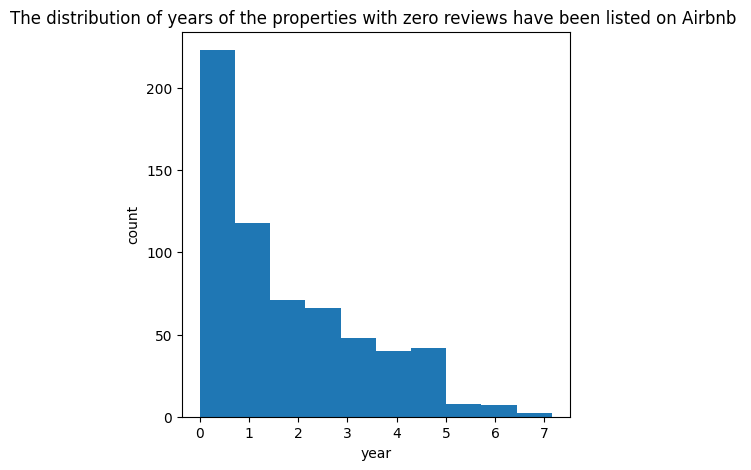

In [529]:
matplotlib.rcParams['figure.figsize'] = (5,5)
(df_listings_filtered_amenities.query("number_of_reviews==0").host_since_deltaDays/365).plot(kind="hist")
ax = plt.gca()
ax.set_title("The distribution of years of the properties with zero reviews have been listed on Airbnb ")
ax.set_xlabel("year");
ax.set_ylabel("count");

In [530]:
# Drop samples with zero reviews
# We see that the majority of missing values gone with these properties
df_listings_filtered_amenities = df_listings_filtered_amenities.query('number_of_reviews>0')
df_listings_filtered_amenities.isna().mean().sort_values()

host_is_superhost                   0.000000
Family/Kid Friendly                 0.000000
Essentials                          0.000000
Elevator in Building                0.000000
Dryer                               0.000000
Dog(s)                              0.000000
Cat(s)                              0.000000
Carbon Monoxide Detector            0.000000
Fire Extinguisher                   0.000000
Cable TV                            0.000000
Breakfast                           0.000000
Air Conditioning                    0.000000
24-Hour Check-in                    0.000000
reviews_per_month                   0.000000
require_guest_phone_verification    0.000000
require_guest_profile_picture       0.000000
cancellation_policy                 0.000000
Buzzer/Wireless Intercom            0.000000
First Aid Kit                       0.000000
Free Parking on Premises            0.000000
Gym                                 0.000000
Washer                              0.000000
TV        

In [531]:
df_listings_filtered_amenities_cleaned = df_listings_filtered_amenities.copy()

# Fill NA for numeric features
df_listings_filtered_amenities_cleaned.zipcode = df_listings_filtered_amenities_cleaned.zipcode.fillna(df_listings_filtered_amenities_cleaned.zipcode.mode()[0])
feature_fillna_median = ['host_response_time','host_response_rate','security_deposit','cleaning_fee','weekly_price','bedrooms','bathrooms','review_scores_rating','review_scores_communication','review_scores_cleanliness','review_scores_location','review_scores_value','review_scores_accuracy','review_scores_checkin']
df_listings_filtered_amenities_cleaned[feature_fillna_median] = df_listings_filtered_amenities_cleaned[feature_fillna_median].fillna(df_listings_filtered_amenities_cleaned[feature_fillna_median].median())

# Fill NA for object features
feature_fillna_empty =  ['summary','neighbourhood','space','host_about','transit','neighborhood_overview','notes']
df_listings_filtered_amenities_cleaned[feature_fillna_empty] = df_listings_filtered_amenities_cleaned[feature_fillna_empty].fillna('')




In [532]:
# Numerical features
df_num = df_listings_filtered_amenities_cleaned.select_dtypes(exclude='object')
# One hot encoding categorical features
df_cat = pd.get_dummies(df_listings_filtered_amenities_cleaned.select_dtypes(include='object')[['property_type','room_type', 'bed_type']])
# Drop one hot categorical feature columns appearing less then 5% of samples
catFeatureToDrop = df_cat.columns.where(df_cat.mean()<0.05).dropna()
df_cat.drop(catFeatureToDrop,axis=1,inplace=True)
df_cat = df_cat.astype("bool")
df_total = pd.concat([df_num,df_cat],axis=1)

### Q1: Should you choose an Airbnb unit hosted by superhost?

In this seciton, I will analyze the difference between super host and other host. Mainly, I will use two independent t-test to find features whose mean value is significantly different between properties hosted by super hosts and properties hosted by others.

In [533]:

# Helper function for two independent sample t-test
def ttest(df,group_feature, test_feature):
    flag0 = df[group_feature]==False
    flag1 = ~flag0

    vector_0 = df.loc[flag0,test_feature]
    vector_1 = df.loc[flag1,test_feature]
    statistic, pvalue = stats.ttest_ind(vector_1, vector_0)
    return [statistic,pvalue,test_feature]
    

In [534]:
# T-test
ttest_result = []
for col in df_total.columns:
    if col=="host_is_superhost":
        continue
    else:
        ttest_result.append(ttest(df_total,"host_is_superhost",col))

# Display the t-test result
ttest_result = pd.DataFrame(ttest_result,columns=['statistics','pvalue','feature'])
# P-value adjustment
multitest_result = multi.multipletests(ttest_result.pvalue,method="bonferroni")
ttest_result['significant'],ttest_result['adjust_pvalue']=multitest_result[0],multitest_result[1]
ttest_result.sort_values(['significant','adjust_pvalue'],ascending=[False,True]).style.bar(subset=['statistics'], align='zero', color=['#d65f5f', '#5fba7d'])


,statistics,pvalue,feature,significant,adjust_pvalue
36,15.911607,0.000000,reviews_per_month,True,0.000000
26,13.952008,0.000000,review_scores_rating,True,0.000000
23,13.477553,0.000000,number_of_reviews,True,0.000000
28,13.172330,0.000000,review_scores_cleanliness,True,0.000000
32,12.538164,0.000000,review_scores_value,True,0.000000
27,12.240080,0.000000,review_scores_accuracy,True,0.000000
29,9.388841,0.000000,review_scores_checkin,True,0.000000
30,9.174692,0.000000,review_scores_communication,True,0.000000
65,8.128337,0.000000,Shampoo,True,0.000000
1,7.705804,0.000000,host_response_rate,True,0.000000


# Result Evaluation

In [535]:
# About 44% of the significant features are amenities.
ttest_result.feature[ttest_result.significant==True].isin(unqiue_amenities).sum()/np.sum(ttest_result.significant==True)

0.4411764705882353

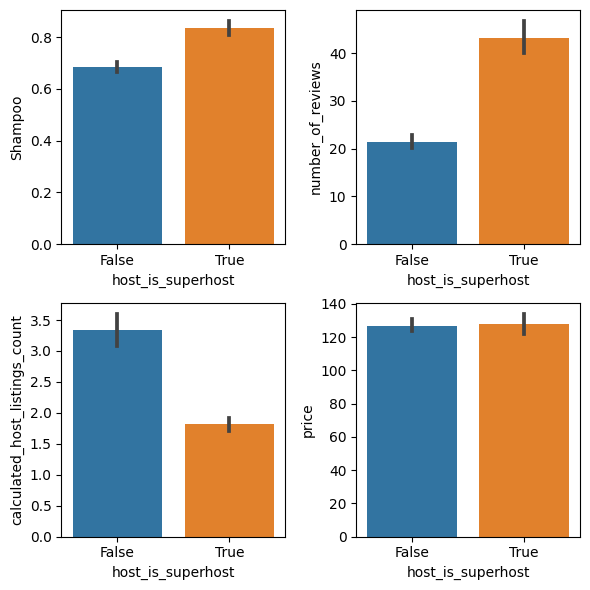

In [536]:
matplotlib.rcParams['figure.figsize'] = (6,6)
plt.subplot(221)
sns.barplot(data=df_total,y="Shampoo",x="host_is_superhost")
plt.subplot(222)
sns.barplot(data=df_total,y="number_of_reviews",x="host_is_superhost")
plt.subplot(223)
sns.barplot(data=df_total,y="calculated_host_listings_count",x="host_is_superhost")
plt.subplot(224)
sns.barplot(data=df_total,y="price",x="host_is_superhost")
plt.tight_layout()


It is not surprised to see that super host got much more reviews and higher ratings. Super host respond to traveler quickly and pay more attention to safety as they ask verification for traveler and also tend to got themselves verified in multiple platforms.   

Among the features significantly distinguish super host from other host, about half of them are amenities. Interestingly, Shampoo is the top impacting factor while kitchen merely scrapes through the significance threshold. This is  understandable as traveler usually got no time for cooking and taking a good shower and have a good sleep is more important for their short-term stay.  
 
Given all the superiority of superhost’s properties, you might be wondering superhost may charge premium price. However, statistically this is not the case. One interesting feature is _calculated_host_listings_count_, which is the number of properties own by the host. It seem like companies and owners owning multiple properties cannot pay enough attention to each properties and super host are usually owners own 1 or 2 properties.

So for Q1, the answer is.. yes! As a traveler you should prioritize airbnb units hosted super host over other airbnb-units. You can enjoy better living condition without being worried about being over charged. However, as super hosts' properties are very popular and you should definitely consider booking ahead.


## Q2: What kind of properties I should look at to ensure it is going to be a successful airbnb unit?

In order to determine the success of an Airbnb unit we need to find a metric. The first thing comes to mind is _reviews_per_month_. However, it is possible that a property could get many reviews but they are simply piles of complains from travelers. Thus, I decide to use the product of _review_scores_rating_ and _reviews_per_month_ as the metric. 

Also, we need to get rid of all the review and rating related features in the data since they are heavily correlated with the response variable. Moreover, I will also drop features related to host because the question is about the attributes of a property a investor should pay attention to.

# Data Modeling

In [537]:
# Create the metric and named it "performance"
df_total['performance'] = df_total.reviews_per_month * df_num.review_scores_rating
# Draw host and review related features
featureToDrop = [f for f in df_total.columns.values if "review" in f or 'host' in f]
featureToDrop

['host_is_superhost',
 'host_response_time',
 'host_response_rate',
 'host_listings_count',
 'host_verificationCount',
 'host_has_profile_pic',
 'host_identity_verified',
 'host_since_deltaDays',
 'calculated_host_listings_count',
 'number_of_reviews',
 'last_review_deltaDays',
 'first_review_deltaDays',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

Our first Ridge Regression model got a r2 score around 0.25. Let's take a look at our data and see if we can improve it.

In [538]:

X = df_total.drop(featureToDrop+['performance'],axis=1)
y = df_total.performance
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 10,100],scoring='r2').fit(X, y)
print("r2 score:{:.3f}".format(clf.score(X,y)))

r2 score:0.253


Let's look at the distribution of the response variable. It looks like a positive skewed distriubtion. I will log-transform all the numeric features in the data set and see if the result can be improved.

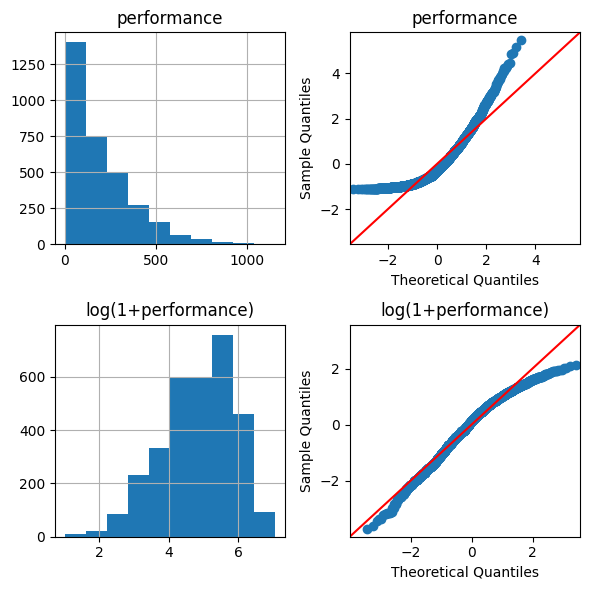

In [539]:
matplotlib.rcParams['figure.figsize'] = (6,6)
fig = plt.figure()


performance = df_total['performance']
log_performance = np.log1p(performance)

ax = fig.add_subplot(2, 2, 1)
performance.hist(ax=ax)
plt.title("performance")

ax = fig.add_subplot(2, 2, 2)
sm.qqplot((performance-performance.mean())/performance.std(),line='45',ax=ax)
plt.title("performance")


ax = fig.add_subplot(2, 2, 3)
log_performance.hist(ax=ax)
plt.title("log(1+performance)")

ax = fig.add_subplot(2, 2, 4)
sm.qqplot((log_performance-log_performance.mean())/log_performance.std(),line='45',ax=ax)
plt.title("log(1+performance)")

plt.tight_layout()


In [540]:
# Choose numeric features
num_feature = df_total.select_dtypes(include="number").dtypes.index.values
# Compute the sknewness, log transform features with abs(skewness)>0.75
skewed_feats = df_total[num_feature].apply(lambda x:x.skew())
skewed_feats = skewed_feats[abs(skewed_feats) > 0.75]
skewed_feats = skewed_feats.index
# Helper function transforming features containing negative values 
# to features only containing nonnegative values
def moveToNonNegative(series):
  if series.min()<0:
    series = series-series.min()
  return series 

df_total[skewed_feats] = df_total[skewed_feats].apply(moveToNonNegative)
df_total[skewed_feats] = np.log1p(df_total[skewed_feats])

In [541]:
X = df_total.drop(featureToDrop+['performance'],axis=1)
y = df_total.performance
clf = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 10,100],scoring='r2').fit(X, y)
print("r2 score:{:.3f}".format(clf.score(X,y)))

r2 score:0.317


Our r2 score just jump to from 0.253 to 0.317. I will stop here and check what the coefficients suggests.

# Result Evaluation

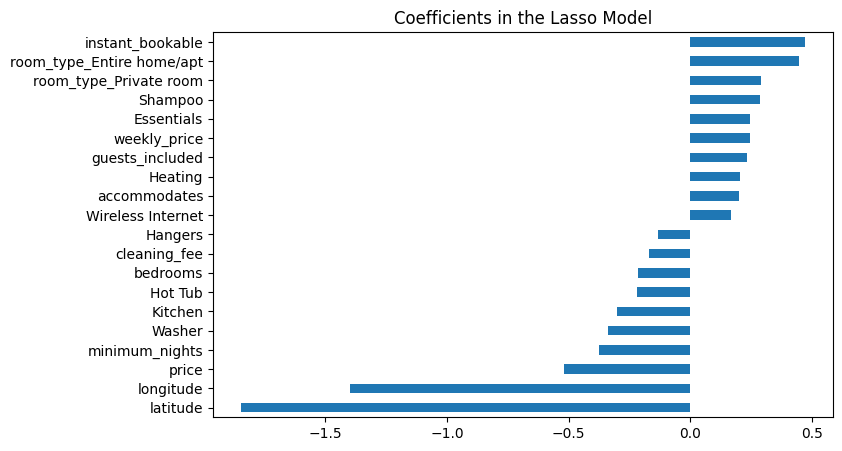

In [542]:
coef = pd.Series(clf.coef_, index = X.columns)
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

By looking at the features with the largest absolute value of coefficents, we can get some insights. While the amentities like _Shampoo_ and _Essentials_ positively contribute to the good performance of a Airbnb unit, properties with _Hot Tub_ could make things worse. It is rare to find a property in downtown with a pool. It is possible that these properties are located in the rural area which are far away from the Seattle's attractions. 

I have never been to Seattle, it is curious to observe that longitude and latitude correspond to the smallest negative coefficients at the bottom. It suggests that people should avoid the northeastern area of Seattle. Out of curiosity , I google the crime rate distribution in Seattle and the result confirms the finding.

So for Q2, the answer is.. you should avoid searching properties in the northeastern area. Apartments in downtown area should be in your priority list. Usually, these luxury properties comes with _Heating_ and _Wireless Internet_. Moreover, you should consider renting out the assest as entire apartment or private rooms instead of shared room.



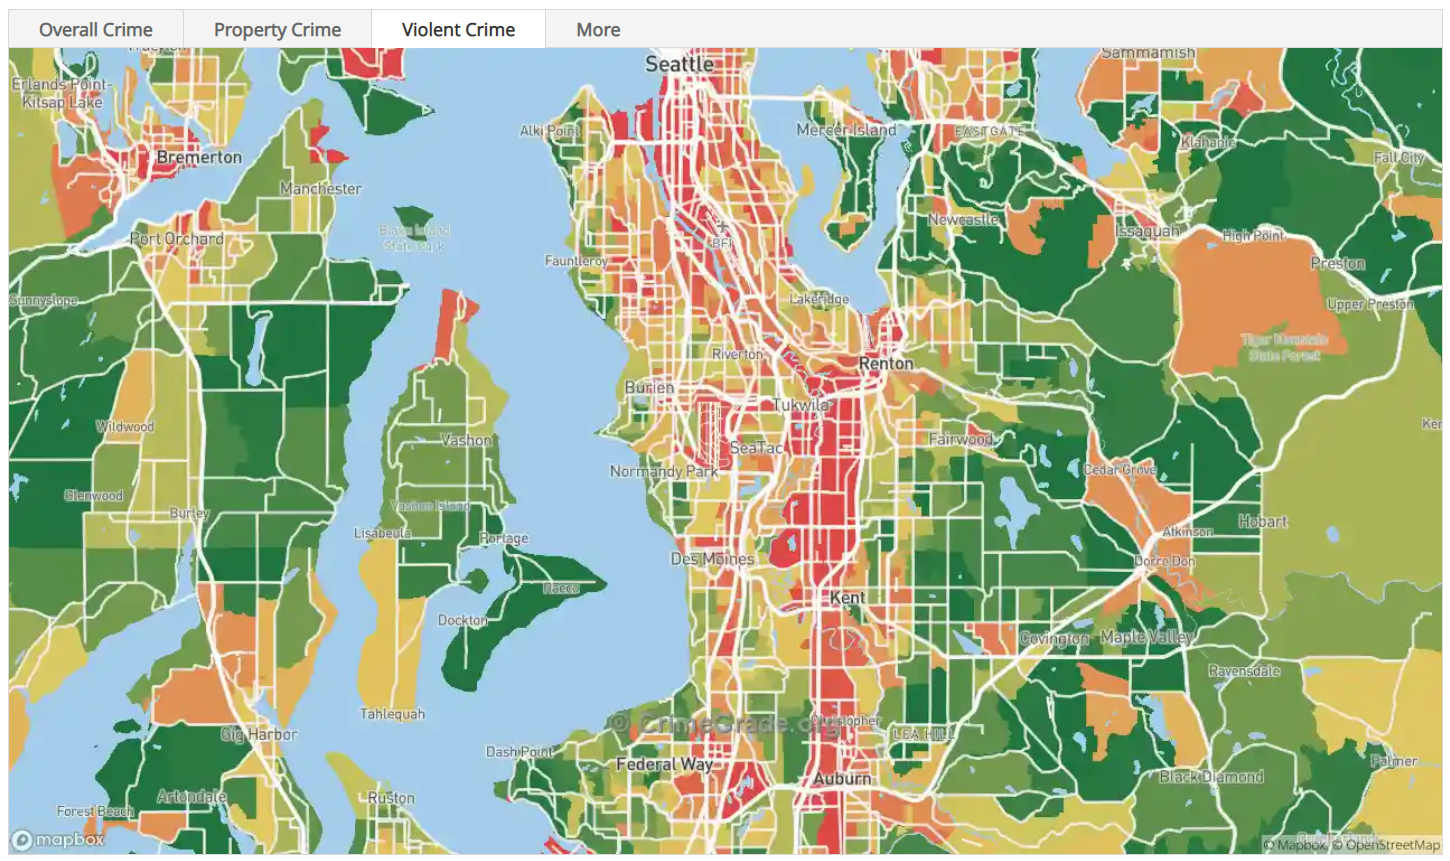

# Q3. How's the development of Airbnb in Seattle? Do you observe any pattern of trend?

In this section, I will dive in the reviews data which stores the date and reviews from 20010 to 2015. I will use the number of review as a metric to reflect the growth of Airbnb in Seattle. Also I can also use metric to see if there is any seasonal trend exists in Airbnb property renting.

In [718]:
# Extract year and month from date feature
df_reviews.date= pd.to_datetime(df_reviews.date)
df_reviews['year'] = df_reviews.date.dt.year
df_reviews['month'] = df_reviews.date.dt.month
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,year,month
0,7369,3721,2009-06-07,20217,Tim,I was staying with Shireen for a weekend and m...,2009,6
1,7369,4700,2009-06-28,21786,Kristin,Shireen was a great hostess and really underst...,2009,6
2,6606,5664,2009-07-17,18085,Vivian,"The Urban Cottage is comfortable, beautiful, f...",2009,7
3,9460,8715,2009-08-31,32825,Serena,"The room was very cozy and clean, much like yo...",2009,8
4,9460,9669,2009-09-10,36769,Elise,This was a great alternative to an impersonal ...,2009,9


In [736]:
review_count = df_reviews.groupby(['year','month'])['comments'].size().reset_index()
# We drop 2009 and 2016 here as they don't contains data for full 12 months
review_count = review_count.loc[(review_count.year<2016) & (review_count.year>2009),:]
# I use log transform here to better observe the seasonal trend between different years
review_count_log = review_count.copy()
review_count_log.comments = np.log(review_count_log.comments)

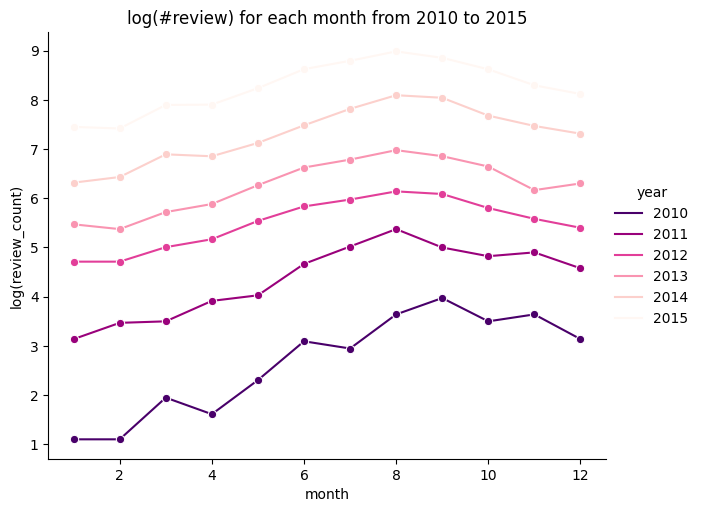

In [738]:
sns.relplot(data=review_count_log,x='month',hue='year',y='comments',marker='o',kind='line',palette="RdPu_r",aspect=10/8)
ax = plt.gca()
ax.set_ylabel("log(review_count)")
ax.set_title("log(#review) for each month from 2010 to 2015")
plt.show()

From the graph above, I can observe that there is a seasonal trend. It seems like August and September are travelers' favourite months to visit Seattle. The demand of Airbnb usually goes down with the freezing weather in January and February.  
Moreover, the number of Airbnb reviews grows each year. The next question is how does the Year over Year growth rate change through all these years.

In [863]:
review_count_pivot = review_count.pivot(index='month',columns='year',values='comments').T
# YoY growth rate per month
review_YoY_perMonth = review_count_pivot.diff()/review_count_pivot.shift()
review_YoY_perMonth = review_YoY_perMonth.dropna()
review_YoY_perMonth = review_YoY_perMonth.stack().reset_index().rename(columns={0:'comments'})

# YoY growh rate per year
review_YoY_perYear = review_count_pivot.sum(axis=1).diff() / review_count_pivot.sum(axis=1).shift()
review_YoY_perYear = review_YoY_perYear.dropna()
review_YoY_perYear = review_YoY_perYear.reset_index().rename(columns={0:'comments'})

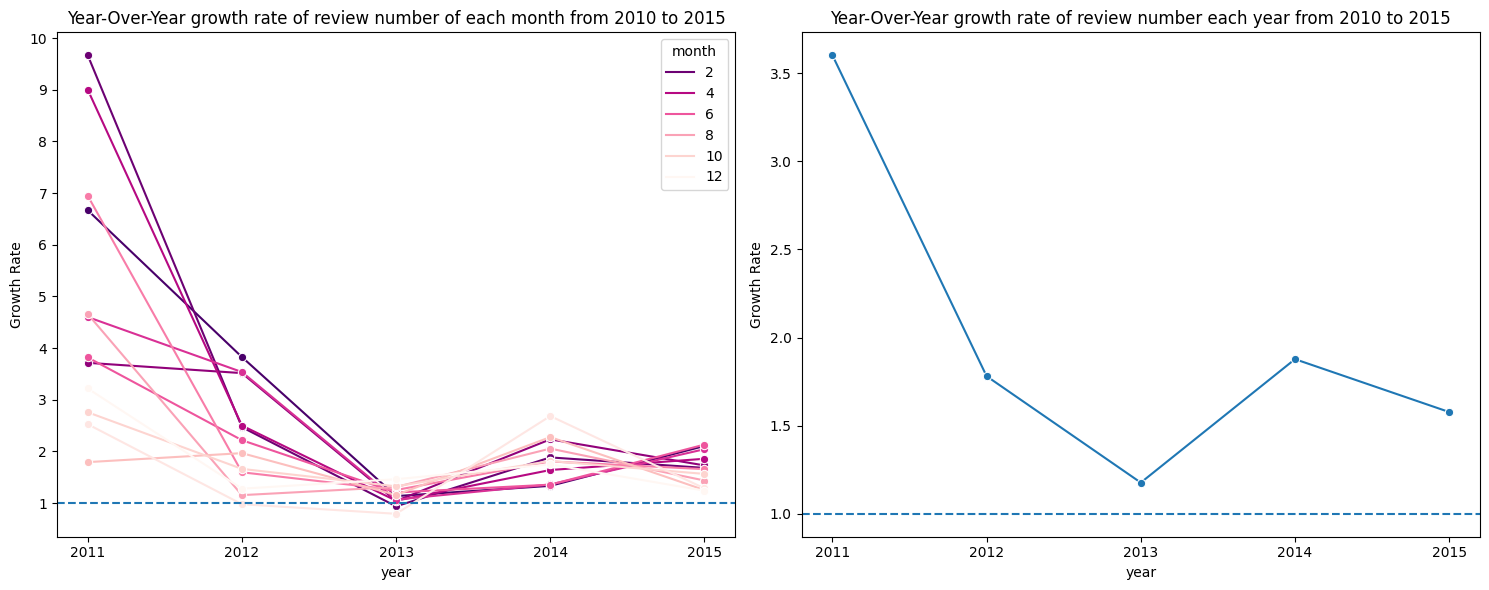

In [876]:
f, axs = plt.subplots(1, 2, figsize=(15, 6))
sns.lineplot(data=review_YoY_perMonth,x='year',hue='month',y='comments',marker='o',palette="RdPu_r",ax=axs[0])
ax = axs[0]
ax.axhline(1, ls='--')
ax.set_xticks([2011,2012,2013,2014,2015])
ax.set_yticks([1,2,3,4,5,6,7,8,9,10])
ax.set_ylabel("Growth Rate")
ax.set_title("Year-Over-Year growth rate of review number of each month from 2010 to 2015")
sns.lineplot(data=review_YoY_perYear,x='year',y='comments',marker='o',palette="RdPu_r",ax=axs[1])
ax = axs[1]
ax.axhline(1, ls='--')
ax.set_xticks([2011,2012,2013,2014,2015])
ax.set_ylabel("Growth Rate")
ax.set_title("Year-Over-Year growth rate of review number each year from 2010 to 2015")
f.tight_layout()

From the left graph above, we could see that from 2011 to 2013, the YoY growth rate for the months in the first half of the year in larger than months in the second half of the year. This trend got reversed after 2013.

From the right graph above, it gives us a more clear view. While the Year-over-Year growth rate remains above 1.0 all these years, there is a major crush in 2012 and 2013. This trend is not rare in business market as the YoY growth rate in the early years could be unstable and misleading. In 2010, Airbnb only got less than 300. Such small number will inevitably exaggerate YoY growth rate in 2011.

So for Q3, we observe that there is a obvious seasonal pattern of Airbnb populairty in Seattle. August and September are the busiest months for Seattle Airbnb host.  The development of Airbnb in Seattle is promising all these years. We should carefully interprect the YoY growth rate in 2011 and don't let us fall into the trap of having misconceptions about the Airbnb was in a developmental setback.
